# 🛠️ 1. Preparación de los Datos

## 1.1. Extracción del Archivo Tratado

In [74]:
# Paso 1.1: Extracción del Archivo Tratado

# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Creación de carpeta para los gráficos generados
import os
output_dir = "reportes_graficos"
os.makedirs(output_dir, exist_ok=True)

# Importación de los datos tratados en el Proyecto 2 y
# almacenamiento en un DataFrame.
df_inicial = pd.read_csv('/content/datos_tratados.csv')
print(df_inicial.sample(5))
print(df_inicial.info())

      gender  senior_citizen  partner  dependents  tenure  phone_service  \
5414       0               1        0           0      26              1   
2087       0               0        1           1      40              1   
177        0               0        1           1      66              0   
2852       1               0        0           0      28              1   
6536       0               0        1           0      64              1   

      paperless_billing  charges_monthly  charges_total  churn  ...  \
5414                  1            93.60        2404.10      0  ...   
2087                  1           110.10        4469.10      0  ...   
177                   0            50.55        3364.55      0  ...   
2852                  1            80.60        2244.95      0  ...   
6536                  1           105.25        6823.40      0  ...   

      streamingmovies_no  streamingmovies_no_internet_service  \
5414                 0.0                           

## 1.2 Eliminación de columnas redundantes y Encoding

Después de la extracción del archivo tratado, se realizarán los siguientes pasos.

* ***Eliminación de columnas redundantes:*** en la Parte 1 se eliminó la columna de CustomerID.
* ***Encoding:*** en la parte 1 se utilizó One Hot Encoding durante la limpieza de los datos para las variables categóricas multiclase.
* ***Verificación*** de la proporción de Churn.
* ***Balanceo de clases***.

Con respecto al paso faltante, la Normalización/Estandarización (según sea necesario) se realizará en el siguiente paso, pues esta debe no debe ser realizada previa a la separación de la data en conjuntos de entrenamiento y prueba. Esto es para evitar la fuga de información desde el conjunto de prueba al conjunto de entrenamiento, que podría generar resultados poco fiables y un desempeño poco realista de los modelos.

Volvamos a los pasos de esta sección. Este Notebook contiene la Parte 2 del proyecto "Challenge Telecom X: evasión de clientes", por lo que algunos pasos ya fueron realizados durante la Parte 1. A saber, ya se eliminó la columna customerID y ya se realizó el Encoding con One Hot Encoding para las variables categóricas multiclase durante la limpieza de los datos. Se escogió OneHotEncoding por su mayor robustez e idoneidad para los modelos predictivos.

Ya que los datos ya fueron tratados, ejecutar nuevamente el código correspondiente a estos pasos mencionados sería redundante. En vez de eso, se adjunta el código relevante asociado a dichos pasos y se prosigue con el encoding de los datos de la Parte 2. El siguiente paso será eliminar variables cuya presencia podría ser perjudicial para los modelos a crear.
```
# Eliminación de columnas redundantes y Encoding de la Parte 1 (Extracto)

# Paso 2.2: transformación de los datos.
# Paso 2.2.1: Normalización de la columnas con datos anidados.
# Se normalizan las variables y se quitan las columnas antiguas.
# Las nuevas variables normalizadas coinciden con lo expuesto en el diccionario
# incluido en el desafío. También  se elimina la columna 'customerID',
# que no aporta al análisis. El resto de las variables se consideran como
# variables útiles para el análisis de evasión, a menos que se demuestre lo
# contrario en pasos posteriores.
df_normalizado = pd.concat([
    pd.json_normalize(df['customer']), pd.json_normalize(df['phone']),
    pd.json_normalize(df['internet']), pd.json_normalize(df['account']),
     (df.drop(['customer', 'phone', 'internet', 'account', 'customerID'], axis=1)),
    ], axis=1)
print('Esta es la información del dataframe normalizado.')
print(df_normalizado.info())
print('\n\n')
print('Estos son los tipos de datos de las columnas del dataframe normalizado.')
print(df_normalizado.dtypes)
print('\n\n')
print('Esta es la suma de los valores nulos del dataframe normalizado.')
print(df_normalizado.isnull().sum())


# Paso 2.2.3.3: Variables categóricas multiclase: OneHotEncoding
# Finalmente, importamos las librerías necesarias y transformamos dichas
# variables en una secuencia de 0s y 1s usando OneHotEncoding.

# Estas variables corresponden a: MultipleLines, InternetService, OnlineSecurity,
# OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies,
# y Contract.

from sklearn.preprocessing import OneHotEncoder

# Columnas categóricas agrupadas
columnas_categ_mul = [
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
]

# Creación del encoder y transformación de las variables
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
one_hot_enc_array = encoder.fit_transform(df_normalizado[columnas_categ_mul])

# Creación del DataFrame con las variables resultants del OneHotEncoding
# y eliminación de columnas redundantes
one_hot_enc_cols = encoder.get_feature_names_out(columnas_categ_mul)
df_one_hot_enc = pd.DataFrame(one_hot_enc_array, columns=one_hot_enc_cols, index=df_normalizado.index)
df_sin_categ_mul = df_normalizado.drop(columns=columnas_categ_mul)

# Unión del DataFrame limpio con las nuevas columnas OneHotEncoding
df_final = pd.concat([df_sin_categ_mul, df_one_hot_enc], axis=1)

print("DataFrame con todas las variables transformadas:\n")
print(df_final.info())
```
Ahora continuamos con la preparación de los datos de la Parte 2.

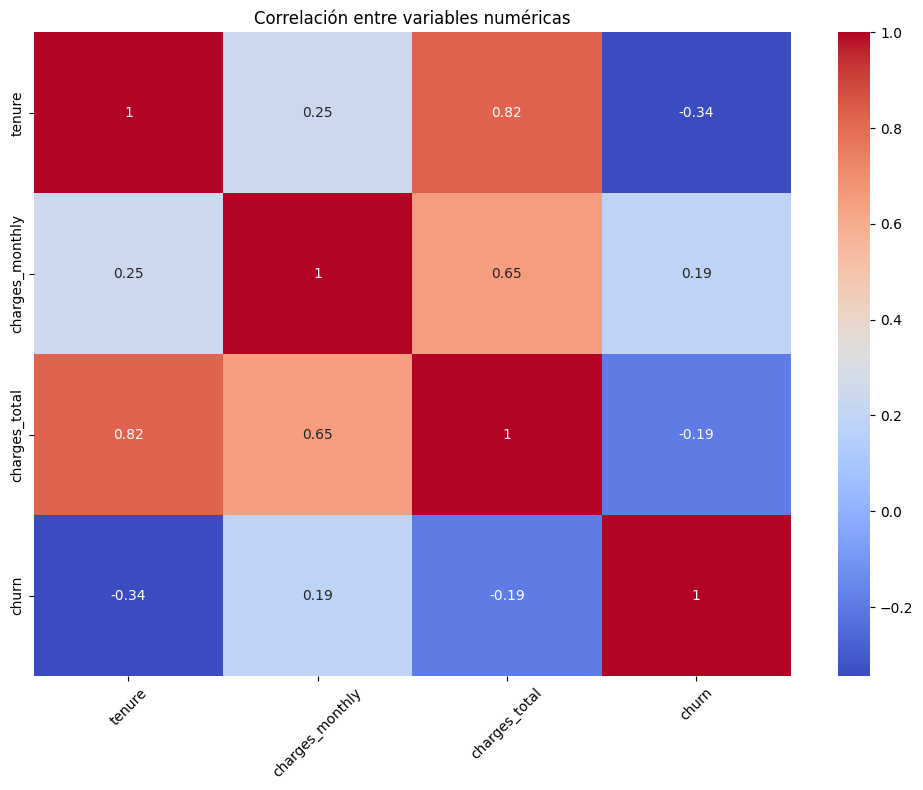

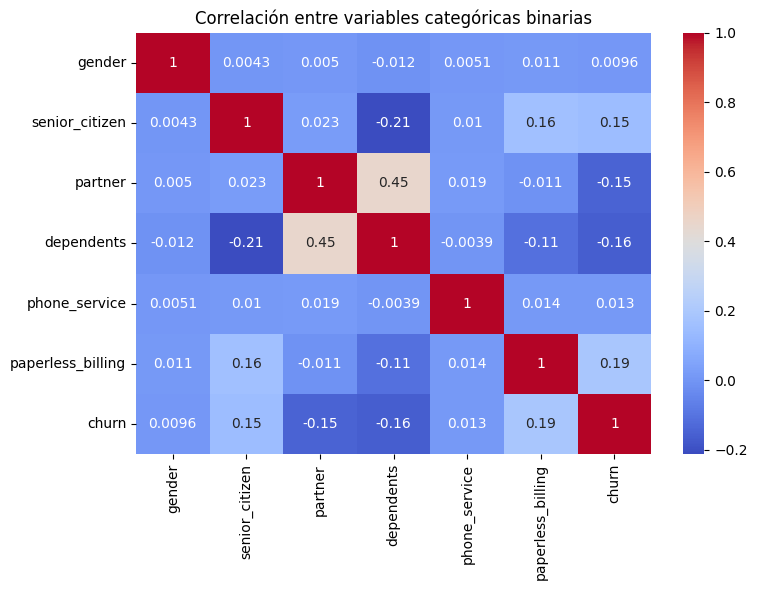

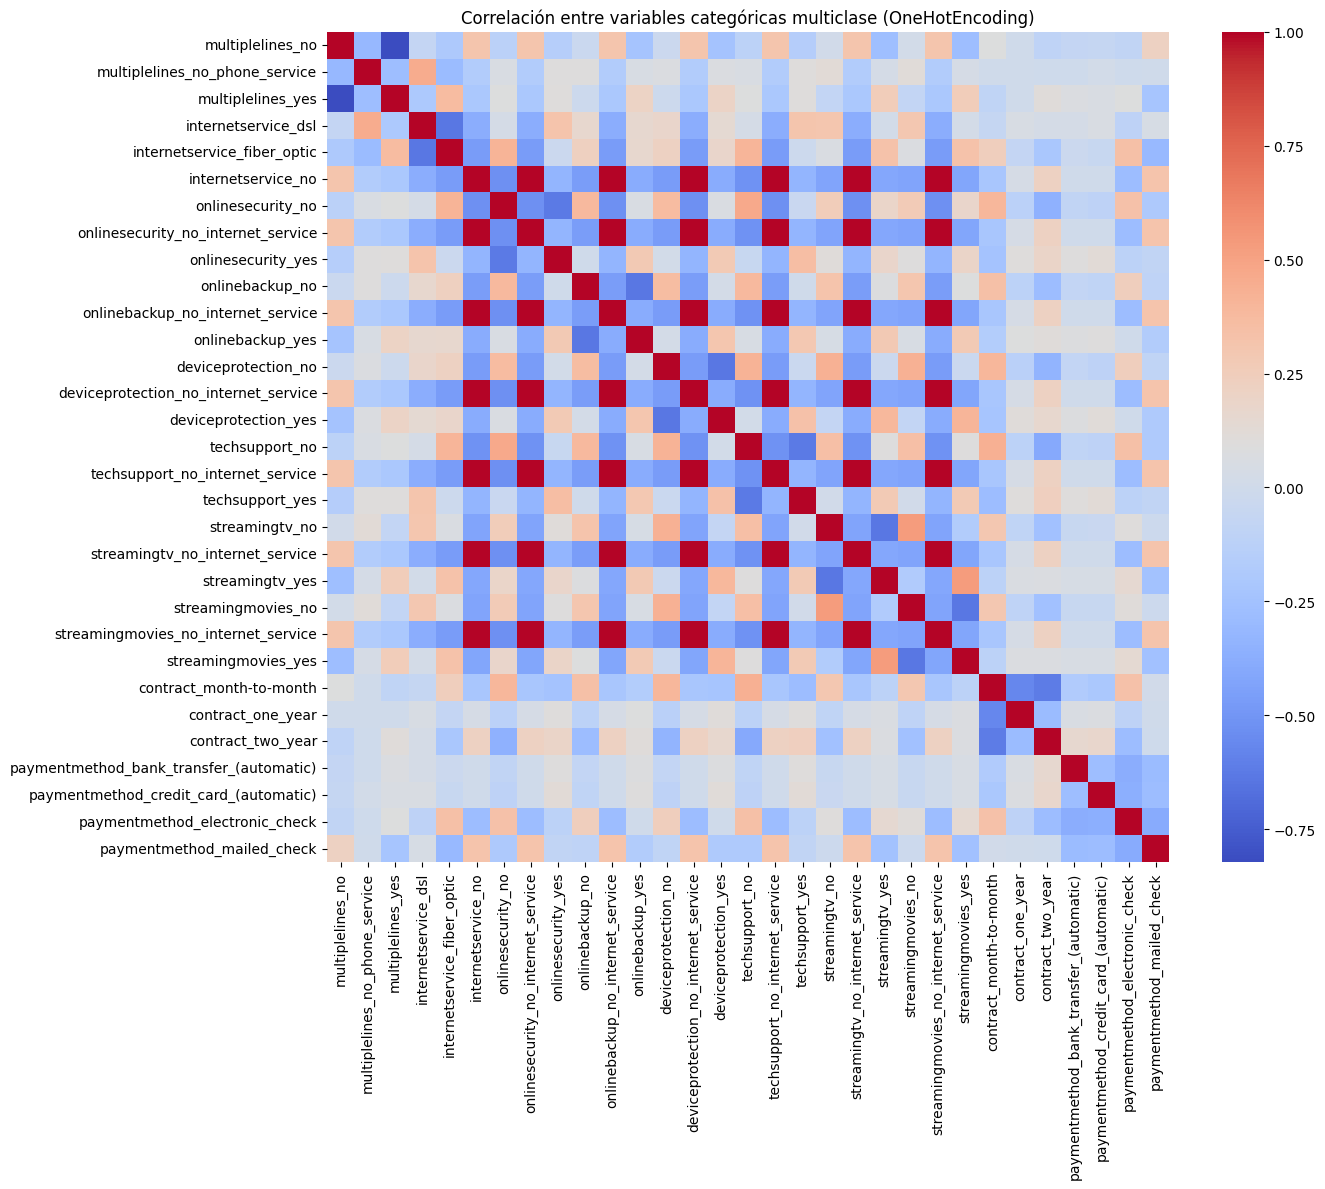

In [75]:
# Paso 1.2: Eliminación de Columnas Irrelevantes y Encoding
# La eliminación de columnas irrelevantes comenzó en la parte 1, donde se
# eliminó la customerID del DataFrame. Además, se utilizaron matrices de
# correlación para identificar posibles variantes redundantes, con altos
# coeficientes de correlación. Ejecutaremos este código nuevamente para
# confirmar y ejecutar los siguientes pasos. Primero se analizó con matrices de
# correlación, luego se analizaron los coeficientes y se listaron las variables
# que serán eliminadas del DataFrame ahora, en la Parte 2.

# Del Proyecto 2 parte 1: "Análisis de correlación y selección de variables relevantes"
# "Matrices de correlación"
# Primero analizamos las variables numéricas con respecto a Churn
variables_num = ['tenure', 'charges_monthly', 'charges_total', 'churn']
corr_matrix_num = df_inicial[variables_num].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_num, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Luego analizamos las variables categóricas binarias.
variables_cat_binarias = ['gender','senior_citizen','partner','dependents','phone_service','paperless_billing','churn']
corr_matrix_bin = df_inicial[variables_cat_binarias].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_bin, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables categóricas binarias')
plt.tight_layout()
plt.show()

# Finalmente, analizamos las variables categóricas multiclase.
analisis_multiclase = ['tenure', 'charges_monthly', 'charges_total', 'gender','senior_citizen','partner','dependents','phone_service','paperless_billing', 'churn']
columnas_categ_mul = df_inicial.drop(columns=analisis_multiclase)
variables_categ_mul = [col for col in df_inicial.columns if any(prefix.lower() in col for prefix in columnas_categ_mul)]
corr_matrix_mul = df_inicial[variables_categ_mul].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_mul, annot=False, cmap='coolwarm')
plt.title('Correlación entre variables categóricas multiclase (OneHotEncoding)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [76]:
# Comprobamos, ahora usando los índices para complementar a la matriz.
def pares_correlacionados(corr_matrix, umbral=0.95):
    pares = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr = corr_matrix.iloc[i, j]
            if abs(corr) >= umbral:
                pares.append((col1, col2, corr))
    return pares

print("Pares de columnas altamente correlacionados (|corr| >= 0.95):\n")

print("Numéricas:")
pares_num = pares_correlacionados(corr_matrix_num)
if pares_num:
    for col1, col2, corr in pares_num:
        print(f"{col1} con {col2} (corr = {corr:.2f})")
else:
    print("No hay pares altamente correlacionados en las variables numéricas.")

print("\nBinarias:")
pares_bin = pares_correlacionados(corr_matrix_bin)
if pares_bin:
    for col1, col2, corr in pares_bin:
        print(f"{col1} con {col2} (corr = {corr:.2f})")
else:
    print("No hay pares altamente correlacionados en las variables categóricas binarias.")

print("\nMulticlase:")
pares_mul = pares_correlacionados(corr_matrix_mul)
if pares_mul:
    for col1, col2, corr in pares_mul:
        print(f"{col1} con {col2} (corr = {corr:.2f})")
else:
    print("No hay pares altamente correlacionados en las variables categóricas multiclase.")

Pares de columnas altamente correlacionados (|corr| >= 0.95):

Numéricas:
No hay pares altamente correlacionados en las variables numéricas.

Binarias:
No hay pares altamente correlacionados en las variables categóricas binarias.

Multiclase:
internetservice_no con onlinesecurity_no_internet_service (corr = 1.00)
internetservice_no con onlinebackup_no_internet_service (corr = 1.00)
internetservice_no con deviceprotection_no_internet_service (corr = 1.00)
internetservice_no con techsupport_no_internet_service (corr = 1.00)
internetservice_no con streamingtv_no_internet_service (corr = 1.00)
internetservice_no con streamingmovies_no_internet_service (corr = 1.00)
onlinesecurity_no_internet_service con onlinebackup_no_internet_service (corr = 1.00)
onlinesecurity_no_internet_service con deviceprotection_no_internet_service (corr = 1.00)
onlinesecurity_no_internet_service con techsupport_no_internet_service (corr = 1.00)
onlinesecurity_no_internet_service con streamingtv_no_internet_servic

In [77]:
# Con las dos anteriores, proveniente de la parte 1 del proyecto, podemos ver
# las variables que están altamente correlacionadas. En el presente análisis,
# entonces, dichas variables serán eliminadas, para así evitar data redundante
# que pueda generar overfitting o alteraciones innecesarias a futuro.
# Para ello usaremos la variable que dejamos declarada en la parte 1.

drop_futuro = ['onlinesecurity_no_internet_service',
               'onlinebackup_no_internet_service',
               'deviceprotection_no_internet_service',
               'techsupport_no_internet_service',
               'streamingtv_no_internet_service',
               'streamingmovies_no_internet_service',
               'multiplelines_no_phone_service']
df_inicial = df_inicial.drop(columns=drop_futuro)
# Esto eliminará las variables mencionadas, dejándonos con
# 34 variables en total, en vez de 41 (eliminaremos 7 variables).
# A diferencia del anterior, al analizar nuevamente se encontró que la
# variable multiplelines_no_phone_service también presentaba una alta
# correlación y, por lo tanto, se agregó a drop_futuro.

In [78]:
# Comprobamos el drop
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7267 non-null   int64  
 1   senior_citizen                           7267 non-null   int64  
 2   partner                                  7267 non-null   int64  
 3   dependents                               7267 non-null   int64  
 4   tenure                                   7267 non-null   int64  
 5   phone_service                            7267 non-null   int64  
 6   paperless_billing                        7267 non-null   int64  
 7   charges_monthly                          7267 non-null   float64
 8   charges_total                            7267 non-null   float64
 9   churn                                    7267 non-null   int64  
 10  multiplelines_no                         7267 no

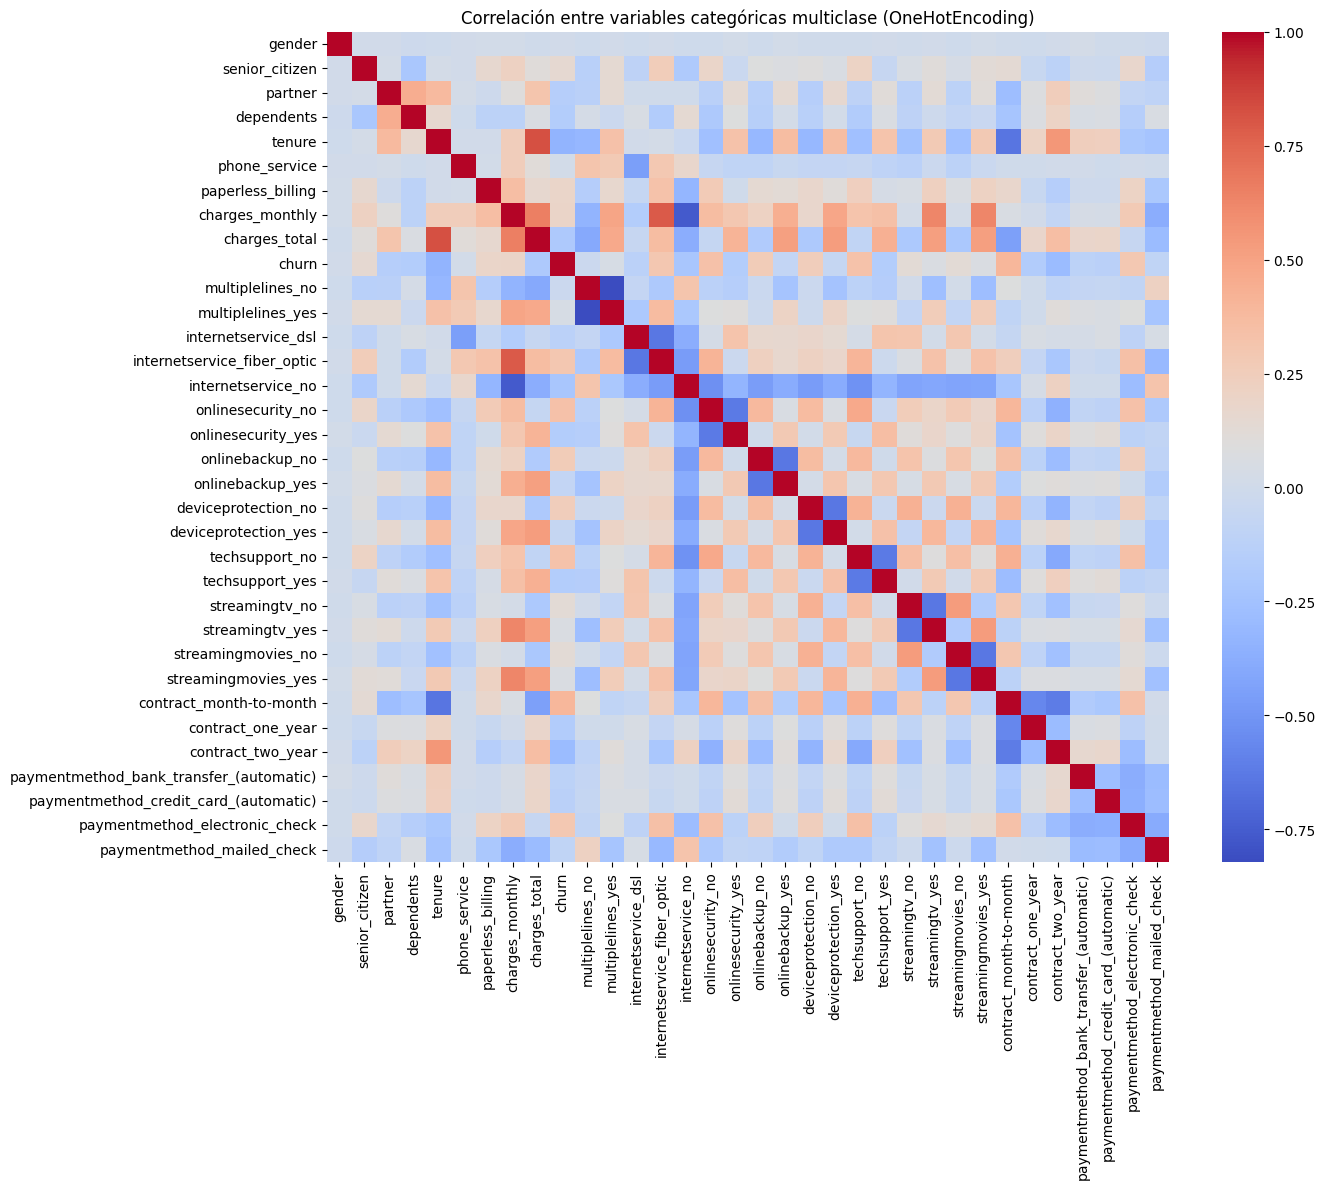

Pares de columnas altamente correlacionados (|corr| >= 0.95):

Numéricas:
No hay pares altamente correlacionados en las variables numéricas.

Binarias:
No hay pares altamente correlacionados en las variables categóricas binarias.

Multiclase:
No hay pares altamente correlacionados en las variables categóricas multiclase.


In [79]:
corr_matrix_mul = df_inicial.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_mul, annot=False, cmap='coolwarm')
plt.title('Correlación entre variables categóricas multiclase (OneHotEncoding)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Pares de columnas altamente correlacionados (|corr| >= 0.95):\n")

print("Numéricas:")
pares_num = pares_correlacionados(corr_matrix_num)
if pares_num:
    for col1, col2, corr in pares_num:
        print(f"{col1} con {col2} (corr = {corr:.2f})")
else:
    print("No hay pares altamente correlacionados en las variables numéricas.")

print("\nBinarias:")
pares_bin = pares_correlacionados(corr_matrix_bin)
if pares_bin:
    for col1, col2, corr in pares_bin:
        print(f"{col1} con {col2} (corr = {corr:.2f})")
else:
    print("No hay pares altamente correlacionados en las variables categóricas binarias.")

print("\nMulticlase:")
pares_mul = pares_correlacionados(corr_matrix_mul)
if pares_mul:
    for col1, col2, corr in pares_mul:
        print(f"{col1} con {col2} (corr = {corr:.2f})")
else:
    print("No hay pares altamente correlacionados en las variables categóricas multiclase.")

# 1.3 Verificación de la proporción de Churn y Balanceo de Clases

In [80]:
# Paso 1.3 Verificación de la Proporción de Cancelación (Churn)
print('Esta es la proporción de cancelación')
print(df_inicial['churn'].value_counts())
print('\n\n')
print('Esta es la proporción de cancelación como porcentaje del total')
print(df_inicial['churn'].value_counts(normalize=True))
# Como podemos observar, la proporción de "Sí" y "No" en la variable
# de interés Churn está desbalanceado. Esto es de esperarse, pues 1 de cada 4
# clientes cancela su contrato con la empresa. Procederemos ahora al balanceo
# de clases.

Esta es la proporción de cancelación
churn
0    5398
1    1869
Name: count, dtype: int64



Esta es la proporción de cancelación como porcentaje del total
churn
0    0.74281
1    0.25719
Name: proportion, dtype: float64


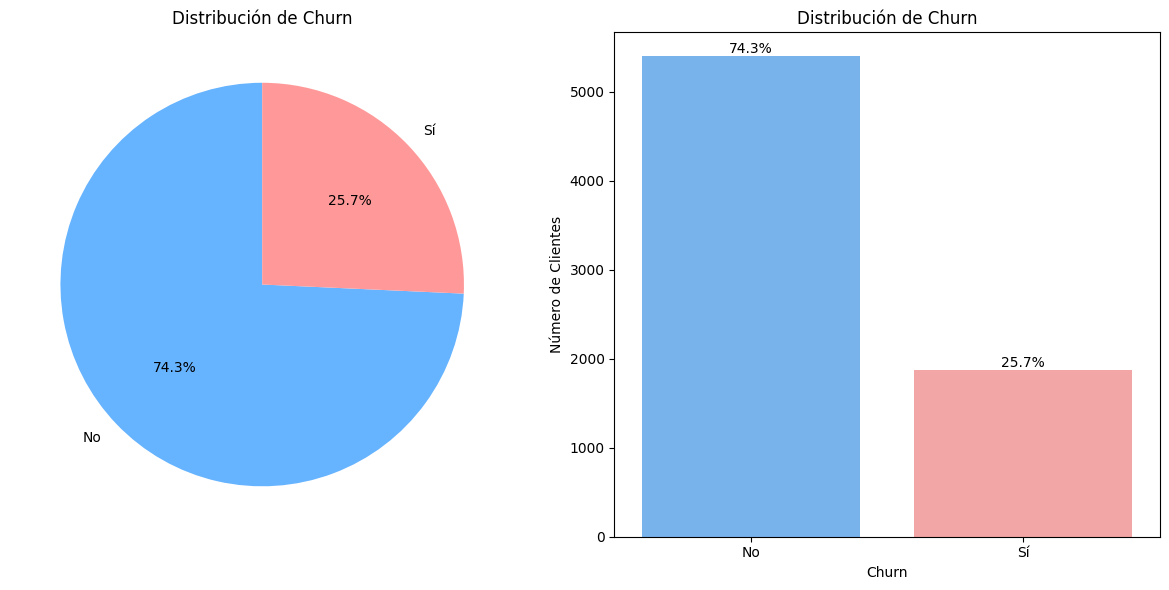

In [81]:
# Gráficos para Churn pre-balanceo
import warnings
warnings.filterwarnings('ignore')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
ax1.pie(df_inicial['churn'].value_counts(),
        labels=['No', 'Sí'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff','#ff9999'])
ax1.set_title('Distribución de Churn')

# Countplot
sns.countplot(data=df_inicial, x='churn', ax=ax2, palette=['#66b3ff','#ff9999'])
ax2.set_title('Distribución de Churn')
ax2.set_xlabel('Churn')
ax2.set_ylabel('Número de Clientes')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['No', 'Sí'])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()/len(df_inicial)*100:.1f}%',
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='bottom')
plt.savefig(os.path.join(output_dir, 'distribucion_y_countplot_churn_original.png'), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

In [82]:
# Paso 1.4: Balanceo de clases
# Para este paso, se ha decidido utilizar SMOTE y así generar ejemplos
# sintéticos para la clase minoritaria
from imblearn.over_sampling import SMOTE

X = df_inicial.drop(['churn'],axis=1)
y = df_inicial['churn']

oversampling = SMOTE()
X_balanceada,y_balanceada = oversampling.fit_resample(X,y)
df_bal = pd.concat([X_balanceada,y_balanceada],axis=1)
print('Esta es la proporción de cancelación después del balanceo de clases')
print(df_bal['churn'].value_counts())
print('\n\n')
print('Esta es la proporción de cancelación después del balanceo de clases como porcentaje del total')
print(df_bal['churn'].value_counts(normalize=True))

Esta es la proporción de cancelación después del balanceo de clases
churn
0    5398
1    5398
Name: count, dtype: int64



Esta es la proporción de cancelación después del balanceo de clases como porcentaje del total
churn
0    0.5
1    0.5
Name: proportion, dtype: float64


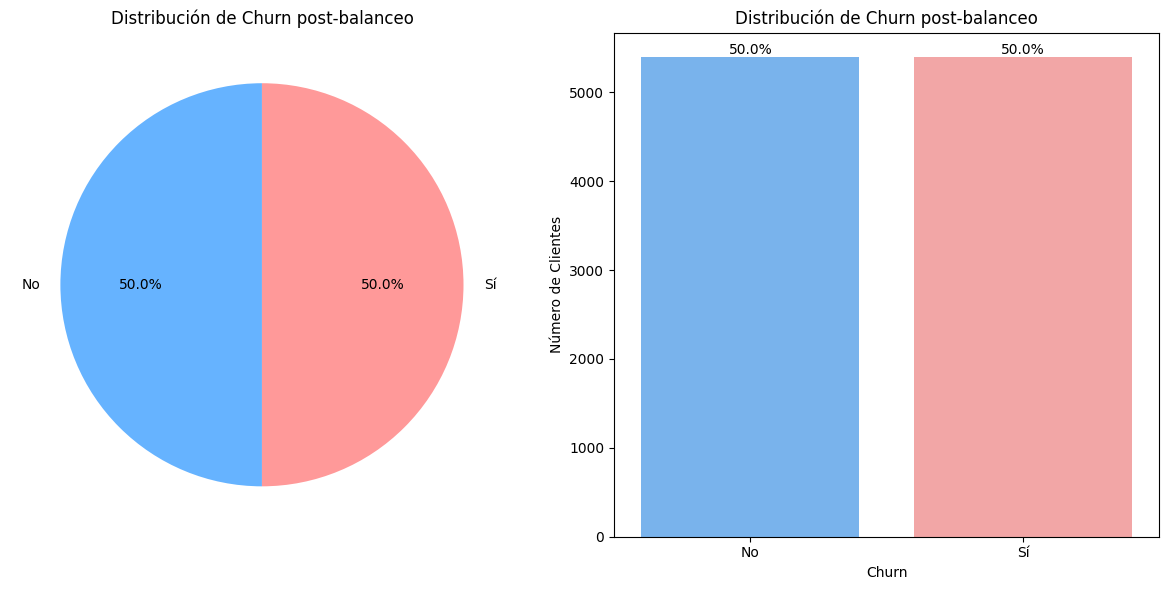

In [83]:
# Gráficos para Churn post-balanceo

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
ax1.pie(df_bal['churn'].value_counts(),
        labels=['No', 'Sí'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff','#ff9999'])
ax1.set_title('Distribución de Churn post-balanceo')

# Countplot
sns.countplot(data=df_bal, x='churn', ax=ax2, palette=['#66b3ff','#ff9999'])
ax2.set_title('Distribución de Churn post-balanceo')
ax2.set_xlabel('Churn')
ax2.set_ylabel('Número de Clientes')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['No', 'Sí'])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()/len(df_bal)*100:.1f}%',
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='bottom')
plt.savefig(os.path.join(output_dir, 'distribucion_y_countplot_churn_balanceado.png'), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

In [84]:
df_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10796 entries, 0 to 10795
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   10796 non-null  int64  
 1   senior_citizen                           10796 non-null  int64  
 2   partner                                  10796 non-null  int64  
 3   dependents                               10796 non-null  int64  
 4   tenure                                   10796 non-null  int64  
 5   phone_service                            10796 non-null  int64  
 6   paperless_billing                        10796 non-null  int64  
 7   charges_monthly                          10796 non-null  float64
 8   charges_total                            10796 non-null  float64
 9   multiplelines_no                         10796 non-null  float64
 10  multiplelines_yes                        10796

# 🎯 2. Correlación y Selección de Variables

# 2.1 Análisis de Correlación

Correlación de las variables numéricas con respecto a Churn:
• Tenure: -0.408
• Charges Monthly: 0.236
• Charges Total: -0.227


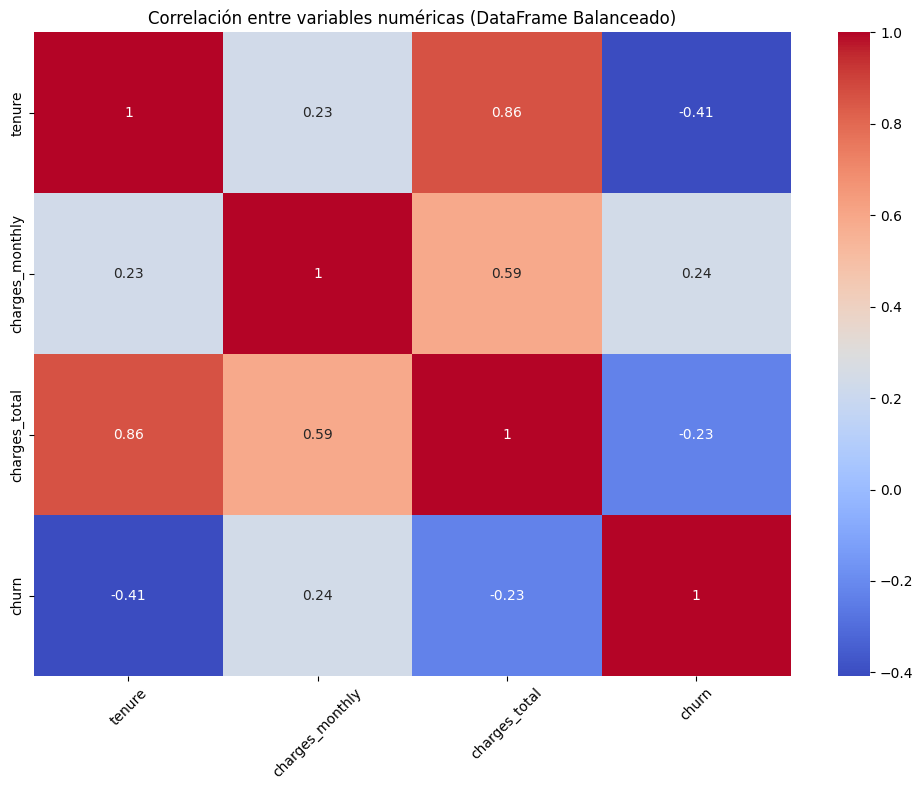

In [85]:
# Paso 2.1: Análisis de Correlación
df_bal_num = df_bal[['tenure','charges_monthly','charges_total','churn']]
corr_matrix_final = df_bal_num.corr()

correlacion_churn = corr_matrix_final['churn'].sort_values(key=abs, ascending=False)
print("Correlación de las variables numéricas con respecto a Churn:")
for var, corr in correlacion_churn.items():
    if var != 'churn':
        print(f"• {var.replace('_', ' ').title()}: {corr:.3f}")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_final, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas (DataFrame Balanceado)')
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_dir, 'correlacion_variables_num.png'), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

# 2.2 Análisis Dirigido

Correlación de las variables que aumentan el Churn:
• Contract Month-To-Month: 0.485
• Onlinesecurity No: 0.408
• Techsupport No: 0.404
• Internetservice Fiber Optic: 0.357
• Paymentmethod Electronic Check: 0.348
• Onlinebackup No: 0.311
• Deviceprotection No: 0.299
• Charges Monthly: 0.236
• Streamingtv No: 0.158
• Streamingmovies No: 0.157
• Paperless Billing: 0.112
• Streamingmovies Yes: 0.068
• Streamingtv Yes: 0.066
• Multiplelines Yes: 0.061
• Senior Citizen: 0.021


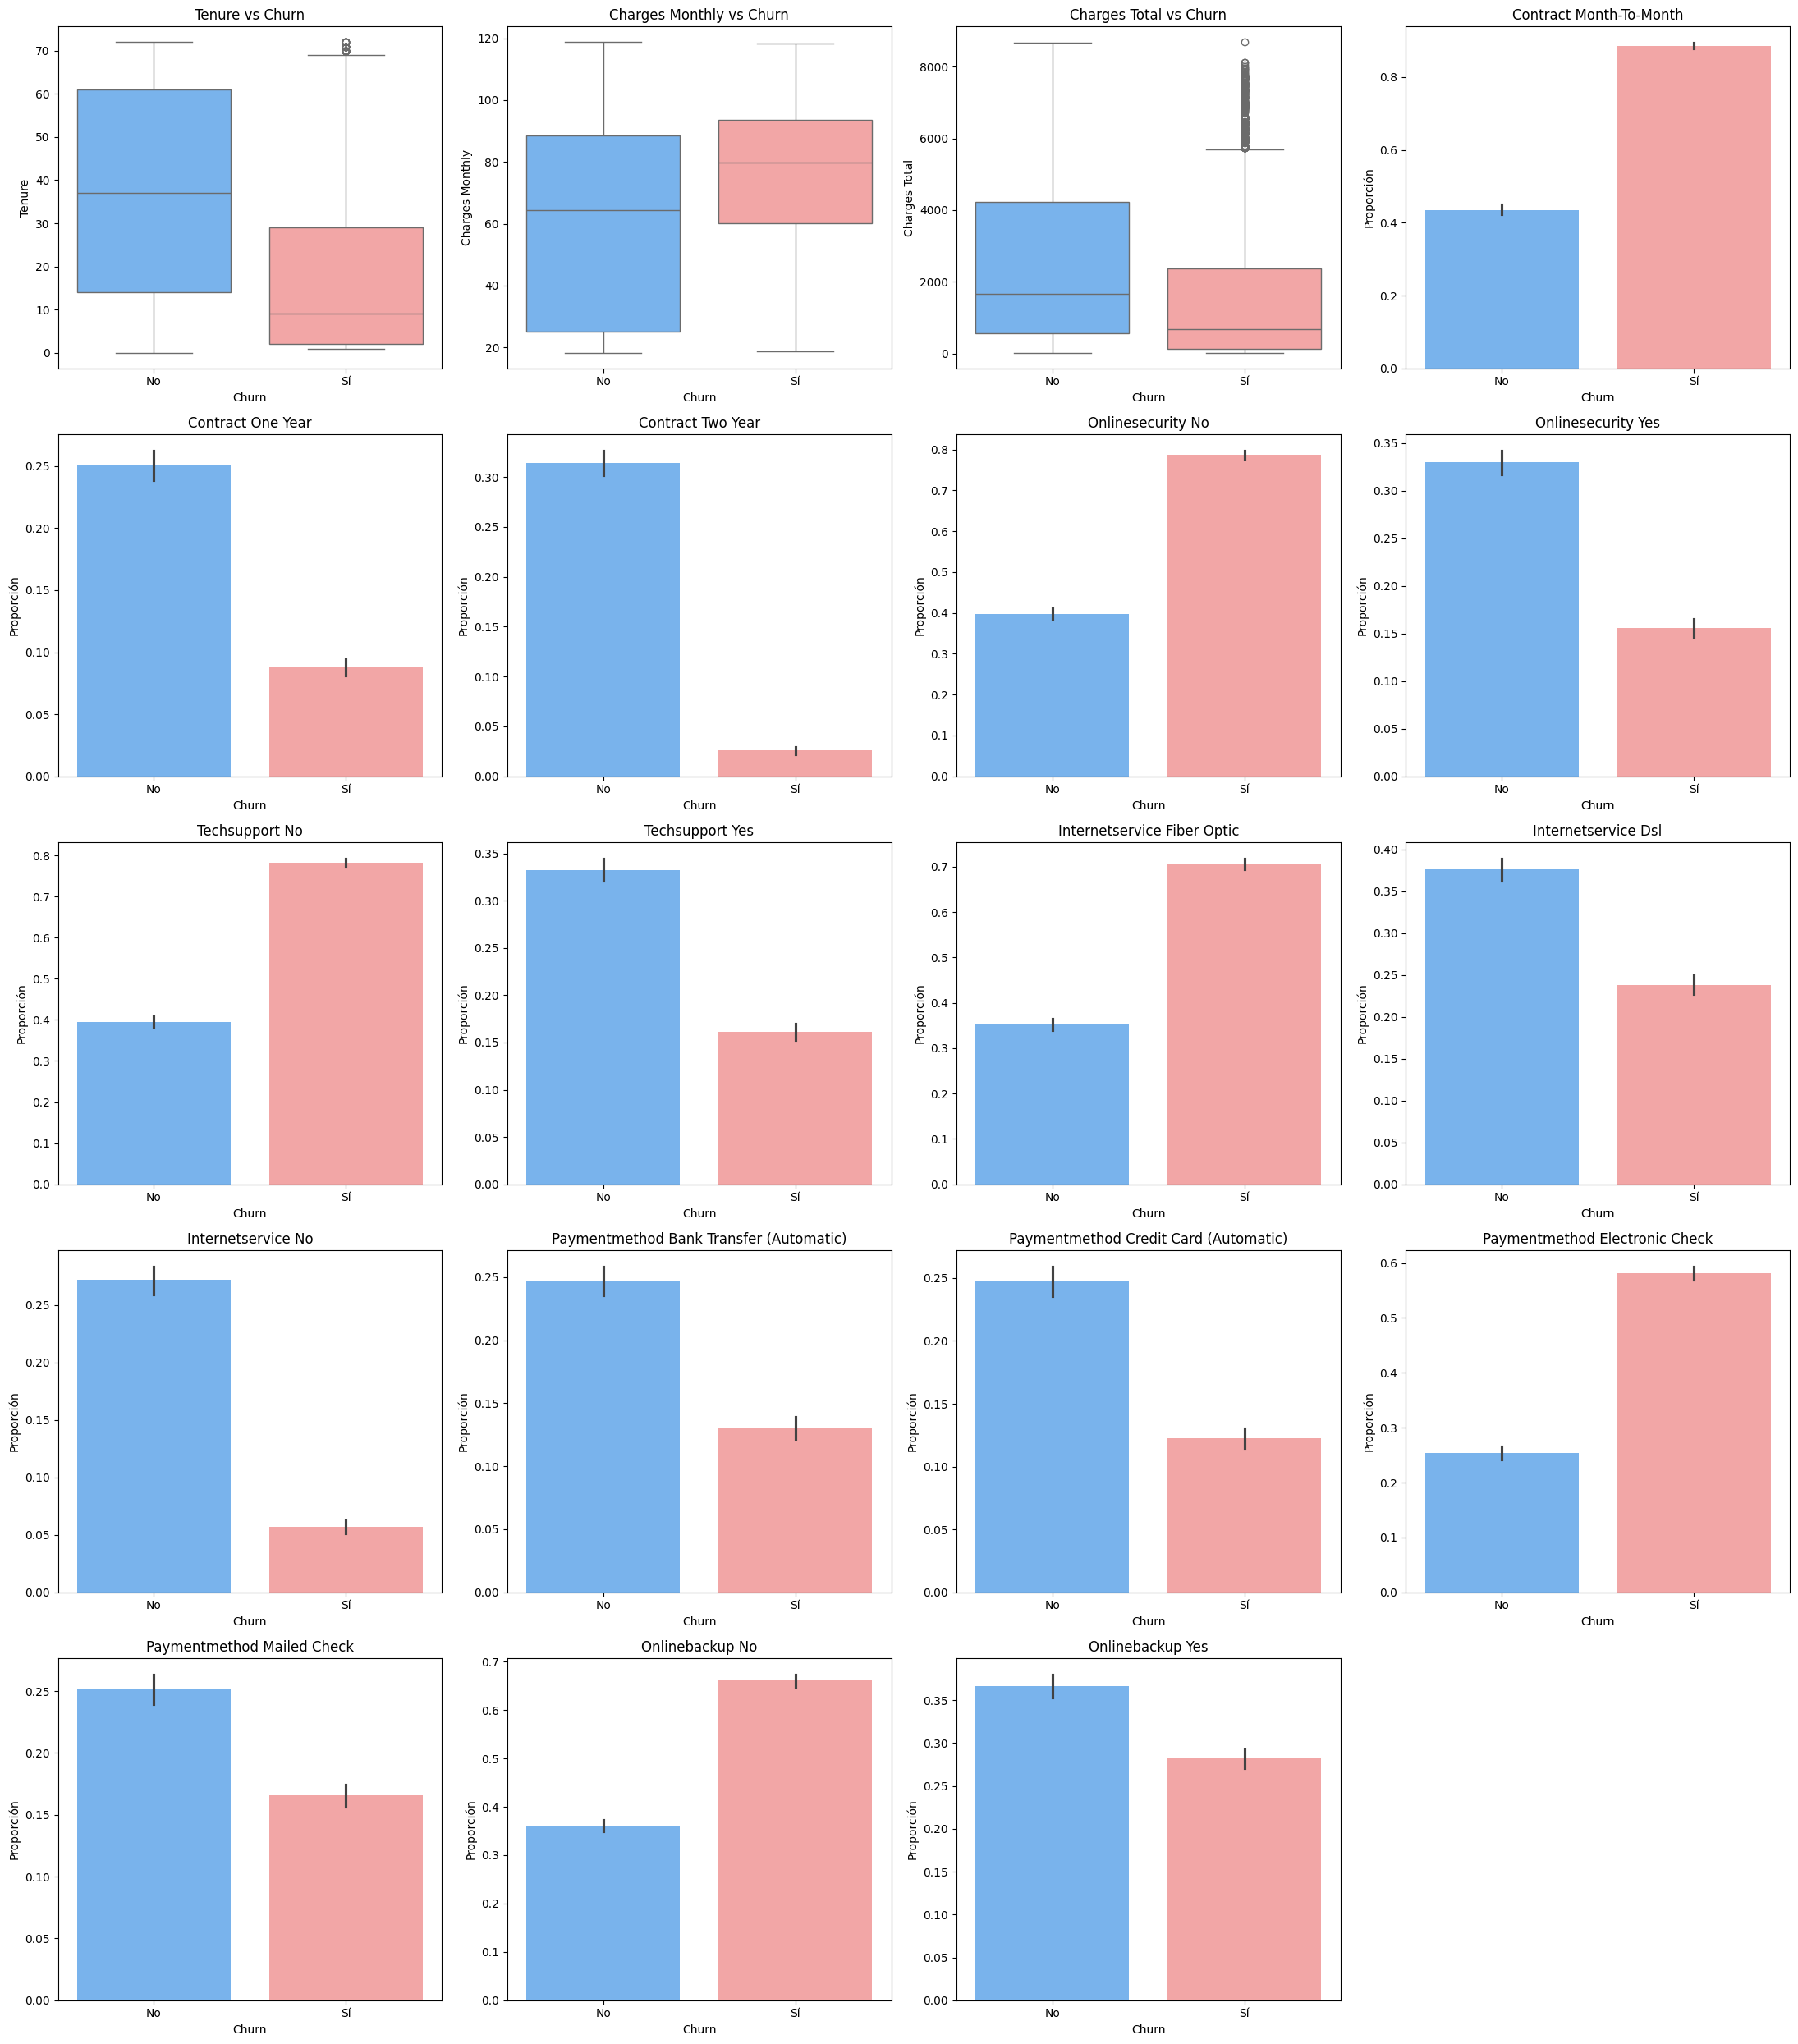

In [86]:
# Paso 2.2: Análisis Dirigido
corr_matrix_final = df_bal.corr()

correlacion_churn = corr_matrix_final['churn'].sort_values(key=abs, ascending=False)
print("Correlación de las variables que aumentan el Churn:")
for var, corr in correlacion_churn.items():
    if var != 'churn' and corr > 0:
        print(f"• {var.replace('_', ' ').title()}: {corr:.3f}")

# Variables numéricas y categóricas
vars_num = ['tenure', 'charges_monthly', 'charges_total']
vars_cat = [
    'contract_month-to-month','contract_one_year','contract_two_year',
    'onlinesecurity_no','onlinesecurity_yes',
    'techsupport_no','techsupport_yes',
    'internetservice_fiber_optic','internetservice_dsl','internetservice_no',
    'paymentmethod_bank_transfer_(automatic)','paymentmethod_credit_card_(automatic)',
    'paymentmethod_electronic_check','paymentmethod_mailed_check',
    'onlinebackup_no','onlinebackup_yes'
]

# Cantidad total de gráficos
total_plots = len(vars_num) + len(vars_cat)

# Grilla: filas y columnas
cols = 4
rows = (total_plots // cols) + int(total_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(22, 5*rows))
axes = axes.flatten()

# Boxplots: numéricas
for i, var in enumerate(vars_num):
    sns.boxplot(data=df_bal, x='churn', y=var, palette=['#66b3ff', '#ff9999'], ax=axes[i])
    axes[i].set_title(f'{var.replace("_", " ").title()} vs Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(var.replace("_", " ").title())
    axes[i].set_xticklabels(['No', 'Sí'])

# Barplots: categóricas
for j, var in enumerate(vars_cat, start=len(vars_num)):
    sns.barplot(data=df_bal, x='churn', y=var, palette=['#66b3ff', '#ff9999'], ax=axes[j])
    axes[j].set_title(var.replace("_", " ").title())
    axes[j].set_xlabel('Churn')
    axes[j].set_ylabel('Proporción')
    axes[j].set_xticklabels(['No', 'Sí'])

for k in range(total_plots, len(axes)):
    fig.delaxes(axes[k])

plt.savefig(os.path.join(output_dir, 'analisis_dirigido.png'), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


# 🤖 3. Modelado Predictivo

In [87]:
# Paso 3.1: Separación de datos
# Importación de librerías y creación de función para evaluación
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calcular_clasificacion(y_test,y_pred):
    metricas = {
        'Accuracy': round(accuracy_score(y_test, y_pred),4),
        'Precision': round(precision_score(y_test, y_pred),4),
        'Recall': round(recall_score(y_test, y_pred),4),
        'F1': round(f1_score(y_test, y_pred),4),
        'AUC': round(roc_auc_score(y_test, y_pred),4)
    }
    return metricas

#Divido la data en variables explicativas y variable respuesta
X = df_bal.drop(['churn'],axis=1)
y = df_bal['churn']

#Luego divido en conjuntos de entrenamiento (train) y prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [88]:
# Paso 3.2: Normalización de Datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Columnas numéricas y categóricas
cols_num = ['tenure','charges_monthly','charges_total']
cols_cat_bin = [col for col in X.columns if col not in cols_num]

# Definimos el transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), cols_num),
        ('cat', 'passthrough', cols_cat_bin)
    ]
)

In [89]:
# Paso 3.3: Creación de modelos
# Paso 3.3.1: Modelo Dummy
# Primero creamos el modelo Dummy usando DummyClassifier() como línea base y le
# damos los datos de los conjuntos de entrenamiento para su funcionamiento y
# evaluación.
baseline = DummyClassifier()
baseline.fit(X_train,y_train) # Entrenamiento Dummy
baseline.score(X_train,y_train) # Exactitud Dummy post-entrenamiento
y_pred_dummy = baseline.predict(X_test) # Predicción Dummy con set de prueba
resultados_baseline = calcular_clasificacion(y_test, y_pred_dummy) # Resultados: evaluación del modelo Dummy

# Paso 3.3.2: Modelo RandomForest
from sklearn.ensemble import RandomForestClassifier
modelo_bosque = RandomForestClassifier(n_estimators = 200, max_depth=10, random_state=42)
modelo_bosque.fit(X_train,y_train) # Entrenamiento RandomForest
modelo_bosque.score(X_train,y_train) # Exactitud RandomForest post-entrenamiento
y_pred_bosque = modelo_bosque.predict(X_test) # Predicción RandomForest con set de prueba
resultados_bosque = calcular_clasificacion(y_test, y_pred_bosque) #Resultados: evaluación del modelo RandomForest

# Paso 3.3.3: Modelo KNN
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
modelo_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=50, leaf_size=40))
])

modelo_knn.fit(X_train, y_train) # Entrenamiento KNN
modelo_knn.score(X_train, y_train) # Exactitud KNN post-entrenamiento
y_pred_knn = modelo_knn.predict(X_test) # Predicción KNN con set de prueba
resultados_knn = calcular_clasificacion(y_test, y_pred_knn) #Resultados: evaluación del modelo KNN


Evaluación del desempeño de los modelos
------------------------------------------


Modelo 1. Se ha creado un Modelo Dummy, el cual sirve de línea base y es el estándar de comparación mínimo.
La exactitud del modelo después de entrenarlo es: 0.5023158869847152
Las métricas de evaluación de este modelo son:
{'Accuracy': 0.4907, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'AUC': np.float64(0.5)}
-----------------------------

Modelo 2. Se ha creado un Modelo Random Forest. Este modelo no requiere normalización.
La exactitud del modelo después de entrenarlo es: 0.889300602130616
Las métricas de evaluación de este modelo son:
{'Accuracy': 0.8398, 'Precision': 0.833, 'Recall': 0.8573, 'F1': 0.845, 'AUC': np.float64(0.8395)}
-----------------------------

Modelo 3. Se ha creado un Modelo KNN. Este modelo requirió normalización de la data.
La exactitud del modelo después de entrenarlo es: 0.778601204261232
Las métricas de evaluación de este modelo son:
{'Accuracy': 0.762, 'Precision': 0.7035

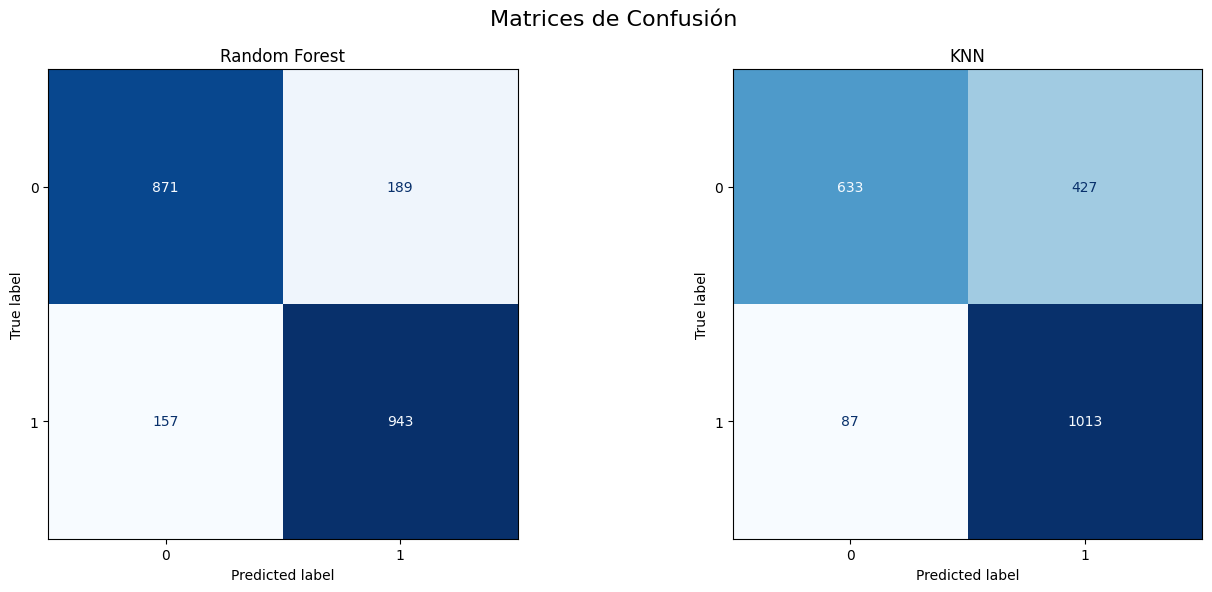

In [90]:
# Paso 3.4: Evaluación de los modelos
print('Evaluación del desempeño de los modelos')
print('------------------------------------------\n\n')
# Paso 3.4.1: Modelo Dummy (Baseline)
print(f'Modelo 1. Se ha creado un Modelo Dummy, el cual sirve de línea base y es el estándar de comparación mínimo.')
print(f'La exactitud del modelo después de entrenarlo es: {baseline.score(X_train,y_train)}')
print(f'Las métricas de evaluación de este modelo son:\n{resultados_baseline}')
print('-----------------------------\n')
# Paso 3.4.2: Modelo RandomForest
print(f'Modelo 2. Se ha creado un Modelo Random Forest. Este modelo no requiere normalización.')
print(f'La exactitud del modelo después de entrenarlo es: {modelo_bosque.score(X_train,y_train)}')
print(f'Las métricas de evaluación de este modelo son:\n{resultados_bosque}')
print('-----------------------------\n')
# Paso 3.4.3: Modelo KNN
print(f'Modelo 3. Se ha creado un Modelo KNN. Este modelo requirió normalización de la data.')
print(f'La exactitud del modelo después de entrenarlo es: {modelo_knn.score(X_train,y_train)}')
print(f'Las métricas de evaluación de este modelo son:\n{resultados_knn}')
# Paso 3.4.4: Comparación de métricas y gráficos
# Métricas
resultados_modelos = {
    'Modelo Dummy': resultados_baseline,
    'Modelo Random Forest': resultados_bosque,
    'Modelo KNN': resultados_knn
}
df_resultados = pd.DataFrame(resultados_modelos)

print('\n\n-----------------------------')
print('Estos son los resultados de los modelos en forma de tabla')
print(df_resultados)
print('\n\n\n')

from sklearn.metrics import classification_report

print('Y estos son los informes por modelo.')
print('Informe: Modelo Dummy')
print(classification_report(y_test, y_pred_dummy))
print('Informe: Modelo Random Forest')
print(classification_report(y_test, y_pred_bosque))
print('Informe: Modelo KNN')
print(classification_report(y_test, y_pred_knn))
print('\n\n\n')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Matriz de confusión: Random Forest
matrix_bosque = confusion_matrix(y_test, y_pred_bosque)
ConfusionMatrixDisplay(confusion_matrix=matrix_bosque,
                       display_labels=modelo_bosque.classes_).plot(ax=ax1, cmap="Blues", colorbar=False)
ax1.set_title("Random Forest")

# Matriz de confusión: KNN
matrix_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(confusion_matrix=matrix_knn,
                       display_labels=modelo_knn.classes_).plot(ax=ax2, cmap="Blues", colorbar=False)
ax2.set_title("KNN")

plt.suptitle('Matrices de Confusión', fontsize=16)

plt.savefig(os.path.join(output_dir, 'matrices_confusion.png'), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


In [102]:
df_resultados.head()

,Modelo Dummy,Modelo Random Forest,Modelo KNN
Accuracy,0.4907,0.8398,0.7620
Precision,0.0000,0.8330,0.7035
Recall,0.0000,0.8573,0.9209
F1,0.0000,0.8450,0.7976
AUC,0.5000,0.8395,0.7590


# 📋 4. Interpretación y Conclusiones

# 4.1 Interpretación de resultados

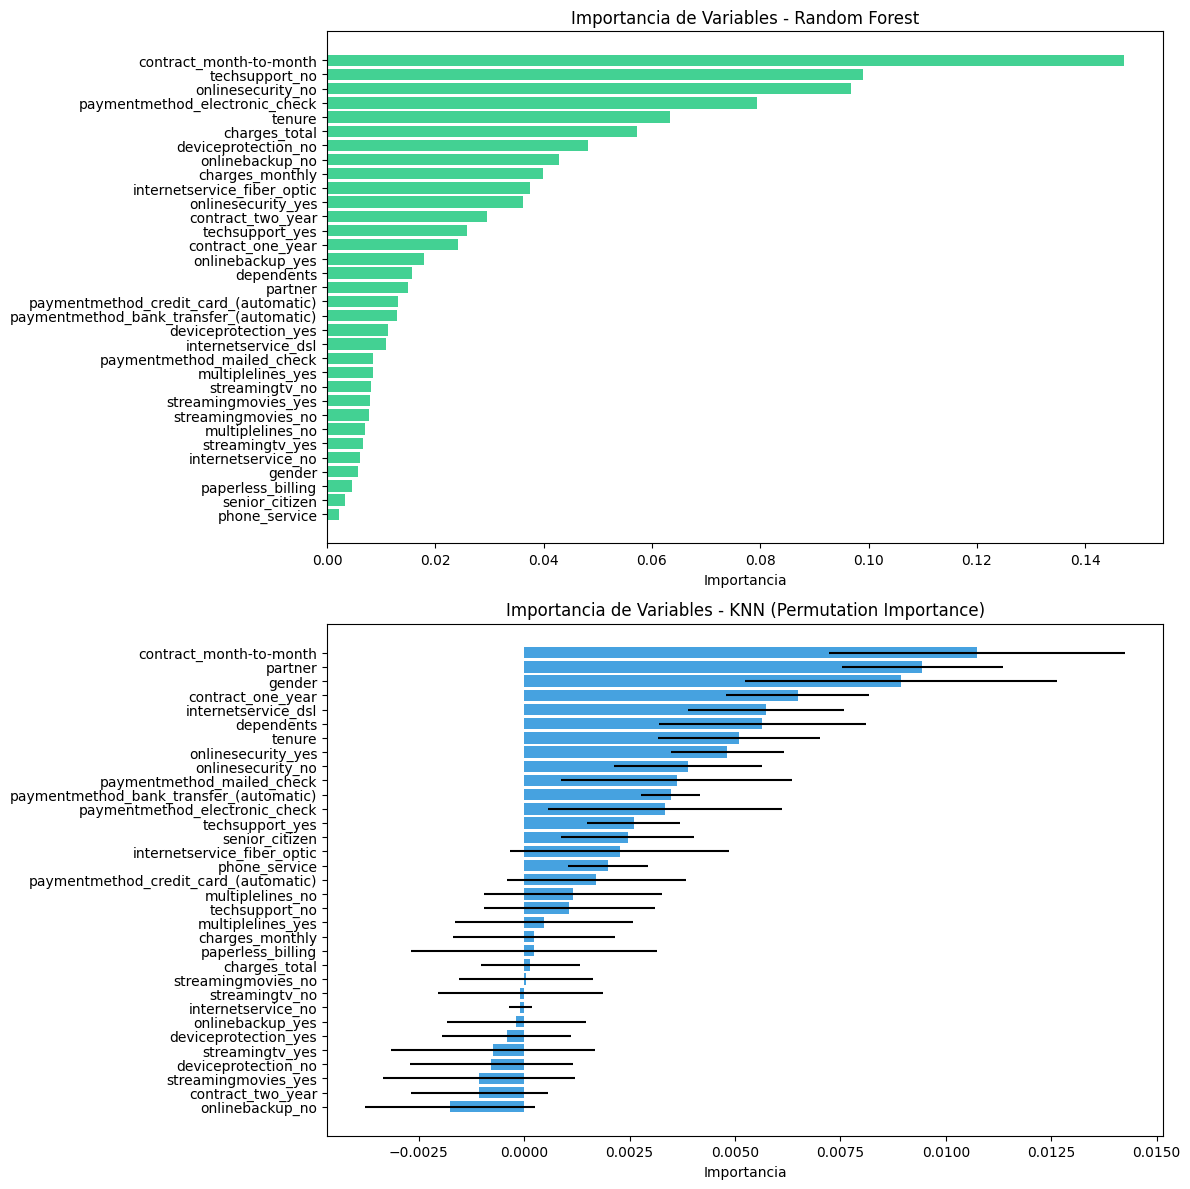

In [92]:
# Paso 4.1: Importancia de las variables de los modelos
# Importancia de variables en Random Forest
importances_rf = modelo_bosque.feature_importances_
features_rf = X_train.columns
indices_rf = np.argsort(importances_rf)[::-1] # Orden: mayor a menor importancia para RF

# Importancia de variables en KNN (Permutation Importance)
from sklearn.inspection import permutation_importance
result_knn = permutation_importance(
    modelo_knn, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)
features_knn = X.columns
importances_knn = result_knn.importances_mean
std_knn = result_knn.importances_std
indices = np.argsort(importances_knn)[::-1] # Orden: mayor a menor importancia para KNN


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Gráfico Random Forest
ax1.barh(range(len(importances_rf)), importances_rf[indices_rf], align="center", color="#43d193")
ax1.set_yticks(range(len(importances_rf)))
ax1.set_yticklabels([features_rf[i] for i in indices_rf])
ax1.set_title("Importancia de Variables - Random Forest")
ax1.set_xlabel("Importancia")
ax1.invert_yaxis()

# Gráfico KNN (Permutation Importance)
ax2.barh(range(len(importances_knn)), importances_knn[indices], xerr=std_knn[indices], align="center", color="#46a2e0")
ax2.set_yticks(range(len(importances_knn)))
ax2.set_yticklabels([features_knn[i] for i in indices])
ax2.set_title("Importancia de Variables - KNN (Permutation Importance)")
ax2.set_xlabel("Importancia")
ax2.invert_yaxis()

plt.savefig(os.path.join(output_dir, 'importancia_variables.png'), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


In [101]:
# Top 10 variables del Modelo RandomForest
top_rf = pd.DataFrame({
    'Variable': [features_rf[i] for i in indices_rf[:10]],
    'Importancia RF': importances_rf[indices_rf[:10]]
})

# Top 10 variables del Modelo KNN
top_knn = pd.DataFrame({
    'Variable': [features_knn[i] for i in indices[:10]],
    'Importancia KNN': importances_knn[indices[:10]],
    'Desviación Estándar KNN': std_knn[indices[:10]]
})

print("Top 10 variables del Modelo Random Forest:")
print(top_rf)
print("\nTop 10 variables del Modelo KNN:")
print(top_knn)

var_mod_rf = top_rf['Variable'].tolist()
var_mod_knn = top_knn['Variable'].tolist()
top_variables = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
fusion = pd.DataFrame({'Modelo Random Forest': var_mod_rf, 'Modelo KNN': var_mod_knn}, index=top_variables)
print("\n\nEstas son las 10 variables más importantes de cada modelo, lado a lado:\n")
print(fusion)

Top 10 variables del Modelo Random Forest:
                         Variable  Importancia RF
0         contract_month-to-month        0.147107
1                  techsupport_no        0.098885
2               onlinesecurity_no        0.096821
3  paymentmethod_electronic_check        0.079408
4                          tenure        0.063290
5                   charges_total        0.057243
6             deviceprotection_no        0.048121
7                 onlinebackup_no        0.042913
8                 charges_monthly        0.039957
9     internetservice_fiber_optic        0.037484

Top 10 variables del Modelo KNN:
                     Variable  Importancia KNN  Desviación Estándar KNN
0     contract_month-to-month         0.010741                 0.003519
1                     partner         0.009444                 0.001911
2                      gender         0.008935                 0.003710
3           contract_one_year         0.006481                 0.001695
4         int

# 4.2 Conclusiones

## Factores relevantes
Para la parte 2 del Challenge "Telecom X: evasión de clientes", se crearon modelos y se predijeron los resultados. Para ello, primero se preparó la data, se verificó la correlación y se seleccionaron variables.

La selección de variables ya había comenzado en la parte 1, donde se realizó One Hot Encoding. Se identificaron variables con alta correlación y en la presente parte 2 se eliminaron para evitar un overfitting. Luego se analizó la correlación nuevamente. Al examinar la matriz de correlación resultante, se notó que no había más variables con correlación excesivamente alta (>0.95), por lo que no se requirió eliminar más variables. Cabe destacar que las variables de Cargos Mensuales y de Tenure se alzaron como variables de importancia para el Churn.

Después se crearon los modelos, se entrenaron y se probaron. Se crearon las matrices de confusión de los modelos y se analizaron sus métricas para evaluar su desempeño. Las matrices de confusión de ambas fueron similares entre sí y un análisis visual preliminar indica que ambos tienen buen desempeño, pero que Random Forest era mejor: la matriz de KNN presentó mayor cantidad de falsos positivos. Esto lo vuelve menos confiable en la práctica.

Ambos modelos, como se puede observar en las tablas de las métricas, son mejores que el Modelo Dummy (Baseline), estableciendo de manera sólida la utilidad de los otros modelos creados: Random Forest y KNN.
Respecto a ellos, el modelo con mejor desempeño final fue el Modelo Random Forest. Esto se debe a sus métricas:

* Tiene un buen Accuracy (0.85), por lo que el modelo realizó predicciones que eran acertadas, es decir, de todas las predicciones realizadas, una alta proporción eran ciertas (identificó a los que cancelan el servicio). El Modelo KNN, en cambio, presenta un Accuracy un poco menor (0.7).
* Las métricas de Precision y Recall de Random Forest son bastante balanceadas entre sí (0.83 y 0.86). Si bien KNN presentó un mejor Recall (0.92), su Precision fue mucho menor (0.70), lo que implica una mayor cantidad de falsos positivos.
* El F1-score refleja lo anteriormente expuesto: el F1-score de Random Forest fue más alto (0.85) que el de KNN (0.80). El AUC refuerza lo anteriormente expuesto con respecto a sus desempeños (0.84 y 0.76, respectivamente).

De esta forma, el modelo seleccionado es el ***Modelo Random Forest***, por su desempeño más balanceado y robusto.

Finalmente, se generaron gráficos y se compararon las 10 variables más importantes de cada modelo. De acuerdo a esto y a los resultados obtenidos del modelo seleccionado, destacamos lo siguiente:
* El factor más importante fue, para ambos y por lejos, los ***contratos mes a mes***.
* Los ***servicios adicionales*** tienen especial relevancia, como lo demuestra la importancia del servicio técnico y el servicio de seguridad online. Estos no fueron los únicos, otros servicios como protección del dispositivo y backup online también son muy relevantes. Clientes que no han contratado estos 4 servicios tienen mayor probabilidad de cancelar su contrato con la empresa que aquellos que sí los contrataron.
* Como se mencionó en la parte 1, el método de pago de cheque electrónico sigue siendo un factor importante.
* La permanencia de un cliente, o ***Tenure***, se mantiene como factor de importancia, siendo los clientes con menor permanencia los que tienen mayor probabilidad de cancelar su contrato. Esto sugiere que invertir en programas de fidelización ayudará a evitar la fuga de clientes.
* Los cargos, tanto totales como mensuales, también mantienen su importancia, confirmando lo hallado en la parte 1.
* Finalmente, el ***servicio de internet por fibra óptica*** continúa siendo un factor relevante, manteniéndose dentro del top 10 del modelo, ratificando su relevancia. Esto sugiere que invertir en programas de fidelización y en mejorar la calidad percibida del servicio de internet podría reducir significativamente la fuga de clientes.

## Recomendaciones
En base a lo anteriormente expuesto, se presentan las siguientes recomendaciones.
1. ***Priorizar los contratos a largo plazo:*** los clientes con contratos cortos, como lo son los de mes a mes, tienden a marcharse más fácil. Sea que los clientes actuales cambien sus contratos a plazos más largos o que los clientes nuevos comiencen con contratos más extendidos, aumentar los contratos de largo plazo disminuirá el churn presente.
2. ***Promover la contratación de servicios adicionales:*** en este aspecto, priorizar los 4 servicios mencionados.
3. ***Promover la permanencia entre los clientes:*** a mayor tiempo con la compañía, menor chances de que cancelen su contrato. Esto es de especial importancia para los clientes nuevos.
4. ***Examinar, diagnosticar e implementar mejoras en el servicio de internet por fibra óptica:*** esclarecer las razones por las que los clientes de este tipo deciden irse e implementar las mejoras necesarias ayudará a que estos clientes experimenten mayor satisfacción con su servicio.